![](pics/header.jpg)

# Mono-Camera Calibration

Kevin J. Walchko, Phd

21 Dec 2020

---


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)

import cv2

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10) # set default figure width

from slurm import storage
from pprint import pprint
from pathlib import Path

In [3]:
from opencv_camera import CameraCalibration
from opencv_camera import drawHorizontalLines
from opencv_camera import ChessboardFinder
from opencv_camera import UnDistort
from opencv_camera import bgr2gray, gray2bgr
from opencv_camera import coverage, mosaic
from opencv_camera import visualizeDistortion
from opencv_camera import computeReprojectionErrors, visualizeReprojErrors

In [12]:
def readImages(path, pattern):
    p = Path(path).glob(pattern)
    p = list(p)
    p.sort()
    return [cv2.imread(str(f),0) for f in p]

imgs = readImages("../../large_dataset/stereo-chessboard-opencv","left*.jpg")
print(f">> Found {len(imgs)} images")

>> Found 13 images


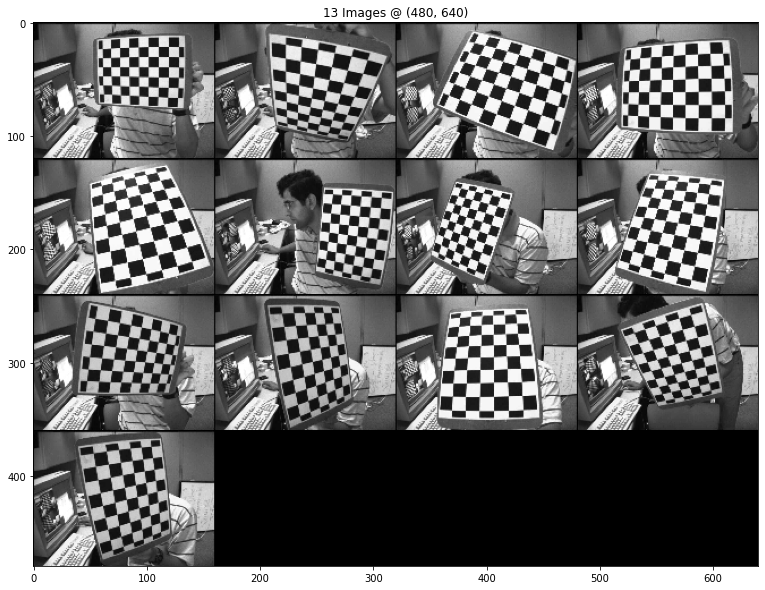

In [13]:
# a simple mosasic of the various images
plt.imshow(mosaic(imgs, width=4), cmap="gray")
plt.title(f"{len(imgs)} Images @ {imgs[0].shape}");

In [14]:
help(CameraCalibration.calibrate)

Help on function calibrate in module opencv_camera.mono.calibrate:

calibrate(self, images, board, flags=None)
    images: an array of grayscale images, all assumed to be the same size.
        If images are not grayscale, then assumed to be in BGR format.
    board: an object that represents your target, i.e., Chessboard
    marker_scale: how big are your markers in the real world, example:
        checkerboard with sides 2 cm, set marker_scale=0.02 so your T matrix
        comes out in meters



In [19]:
calibrator = CameraCalibration()
board = ChessboardFinder((6,9), 1)

cam, cal = calibrator.calibrate(imgs, board)

100%|██████████| 13/13 [00:00<00:00, 60.85it/s]

>> RMS: 0.195px

 Camera[(480, 640)]----------------------
  focalLength(x,y): 532.8 532.9 px 
  principlePoint(x,y): 342.5 233.9 px
  distortionCoeffs: [[-0.281  0.025  0.001 -0.     0.163]]



In [20]:
# lets see what is in the returned dictionary
cal.keys()

dict_keys(['date', 'markerType', 'markerSize', 'imageSize', 'K', 'd', 'rms', 'rvecs', 'tvecs', 'objpoints', 'imgpoints', 'badImages', 'stdint', 'stdext', 'perViewErr'])

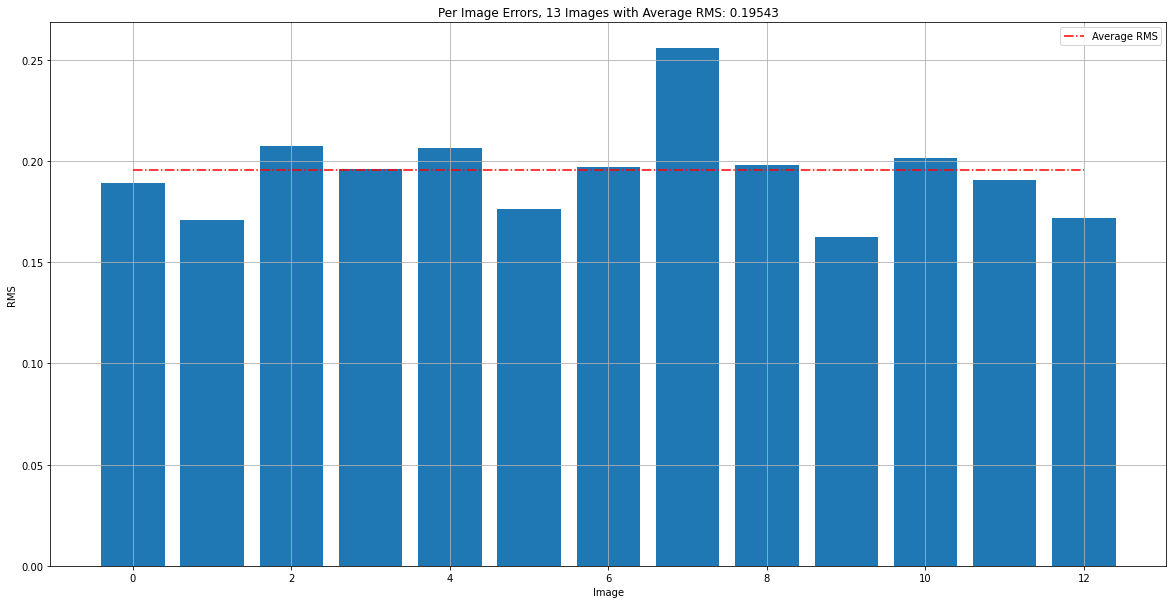

In [21]:
err = cal["perViewErr"].ravel()
plt.bar(range(len(err)), err)
plt.plot(np.ones(len(err))*cal["rms"], "r-.", label="Average RMS")
plt.grid(True)
plt.legend()
plt.ylabel("RMS")
plt.xlabel("Image")
plt.title(f"Per Image Errors, {len(err)} Images with Average RMS: {cal['rms']:0.5f}");

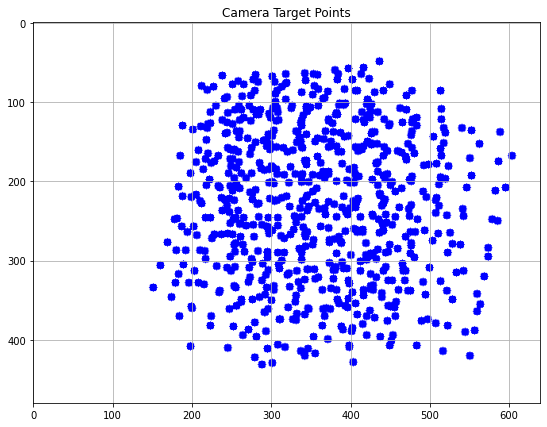

In [22]:
# let's plot where every corner was detected. Notice
# we are not testing the edges of the camera! That 
# is where a lot of distortion occurs from low quality
# lenses. Ideally, you want better coverage.
plt.subplot(1,2,1)
ip = cal["imgpoints"]
icv = coverage((480, 640), ip)
plt.imshow(icv)
plt.grid(True)
plt.title("Camera Target Points");

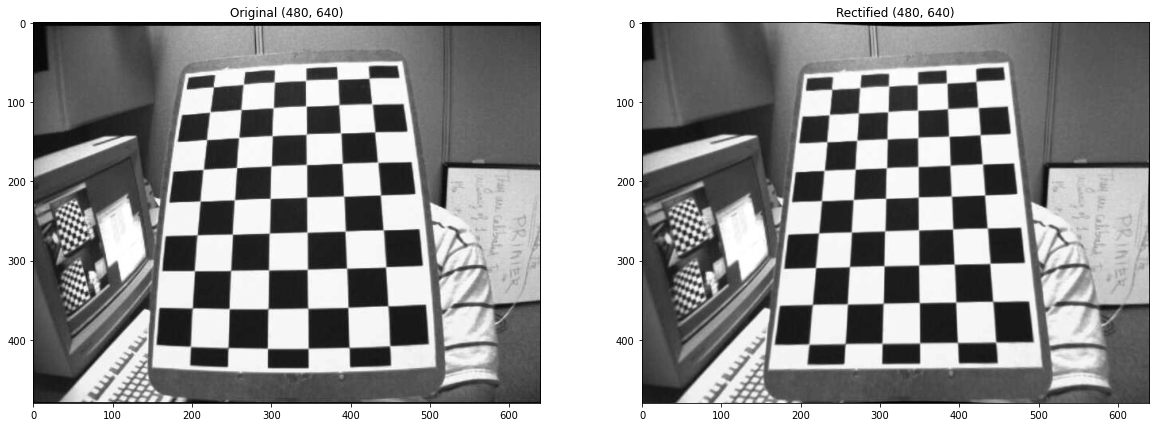

In [23]:
# let's use this info to rectify the image
ud = UnDistort(cal["K"], cal["d"], 480, 640)

im = imgs[10]
corr = ud.undistort(im)

plt.subplot(1,2,1)
plt.imshow(im, cmap="gray")
plt.title(f"Original {im.shape}");

plt.subplot(1,2,2)
plt.imshow(corr, cmap="gray")
plt.title(f"Rectified {corr.shape}");

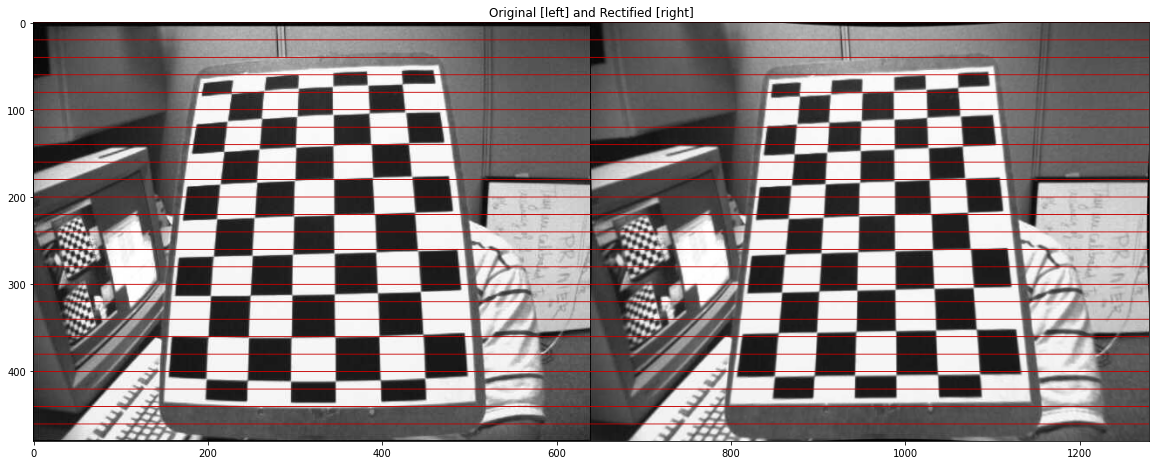

In [24]:
# Maybe the lines will help show the barrel distorition correction 
# a little better. Hopefully, the chessboad lines look straighter in 
# the right image than the original left image.
ep = drawHorizontalLines(im,corr, thickness=1)
plt.imshow(ep)
plt.title("Original [left] and Rectified [right]");

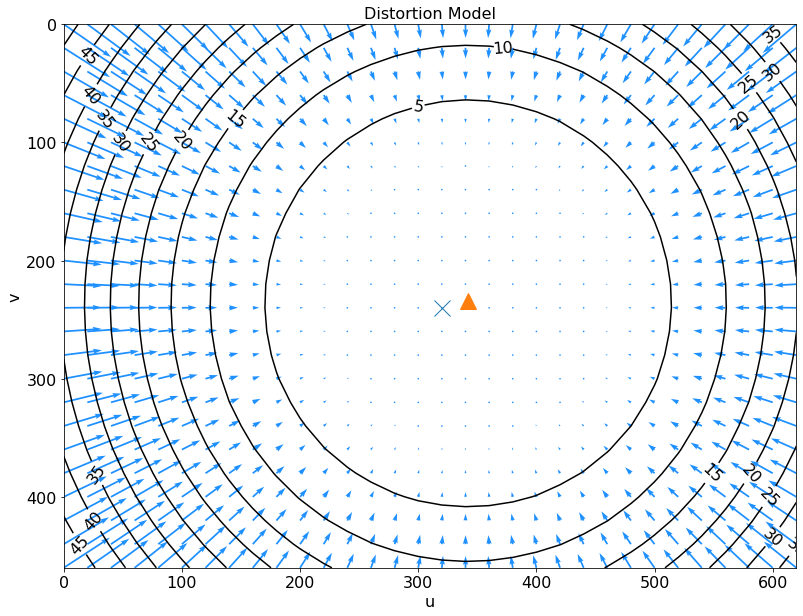

In [25]:
visualizeDistortion(cam.K, cam.d,480,640)

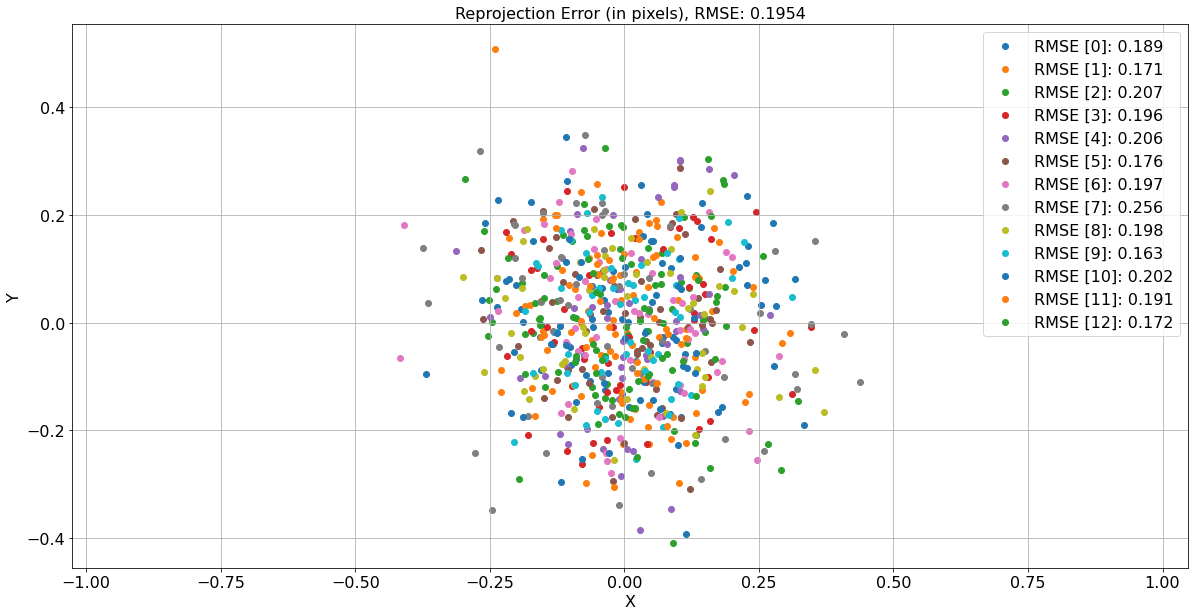

In [26]:
em,rms,xy = computeReprojectionErrors(
    cal["imgpoints"], cal["objpoints"], 
    cal["rvecs"], cal["tvecs"], 
    cal["K"], cal["d"])

visualizeReprojErrors(em, rms, xy,legend=True)

# Save Parameters

So we don't have to run this again, let's save this. I am going to use `pickle`, which is python only, to save the data. This format is not portable to C++ or any other language, but I am only concerned with python. 

In [31]:
cam

Camera(K=array([[532.827,   0.   , 342.487],
       [  0.   , 532.946, 233.856],
       [  0.   ,   0.   ,   1.   ]]), d=array([[-0.281,  0.025,  0.001, -0.   ,  0.163]]), shape=(480, 640))

In [33]:
storage.write("opencv-cal-params.pickle", cam)